# Implementation de l'effet Hong-Ou-Mandel

Dans ce petit notebook, vous pouvez reproduire l'[effet HOM](https://en.wikipedia.org/wiki/Hong%E2%80%93Ou%E2%80%93Mandel_effect).

"L'effet HOM se produit lorsque **deux photons identiques** entrent dans un séparateur de faisceau 1:1, un dans chaque port d'entrée. Lorsque le **chevauchement temporel des photons sur le séparateur de faisceau est parfait**, les deux photons sortent toujours ensemble du séparateur de faisceau dans le même mode de sortie, ce qui signifie qu'il n'y a aucune chance qu'ils sortent séparément"

Ici, nous vous proposons de reproduire cet effet HOM, tout d'abord sur une simulation locale de l'ordinateur quantique (qui est donc une simulation non bruitée), puis, nous vous montrons comment le tester sur le QPU Arcturus, vu à Sherbrooke.

In [3]:
# first we need to install Perceval
# the documentation and source code can be found here: https://perceval.quandela.net
# pip install perceval-quandela

In [109]:
# useful importations to begin with
import os
import perceval as pcvl 
import time
from perceval.algorithm import Sampler

import warnings

warnings.filterwarnings("ignore")

## Simulation

In [110]:

# creation d'un circuit avec 4 modes (max 12 sur Arcturus)
circuit = pcvl.Circuit(4)

# ajout d'un BeamSplitter 1:1
circuit.add(0, pcvl.BS(pcvl.BS.r_to_theta(0.5)))


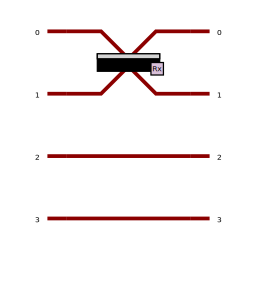

In [111]:
# affichage du circuit
pcvl.pdisplay(circuit)

In [112]:
# choix du back-end de calcul
processor = pcvl.Processor("SLOS")
# envoi du circuit sur le simulateur
processor.set_circuit(circuit)
# choix de la détection des outputs
processor.thresholded_output(False)
# état d'entrée
processor.with_input(pcvl.BasicState('|1,1,0,0>'))

sampler = Sampler(processor)
# simulation avec 1000 répétitions
results = sampler.sample_count(1000)
# résultats
print(results['results'])

{
  |2,0,0,0>: 518
  |0,2,0,0>: 482
}


## Sur le QPU

In [113]:
# choix de la plateforme avec des variables locales
# vous n'avez peut-être pas accès au QPU
platform_name = "qpu:arcturus"
webapi_url = os.environ['QUANDELA_PLATFORM_URL']
token = os.environ['QUANDELA_USER_TOKEN']

In [114]:
# définition du QPU
remote_qpu = pcvl.RemoteProcessor(platform_name, token, webapi_url)
# affichage des specs du QPU
specs = remote_qpu.specs
print(f"Specs = {specs}")

Specs = {'available_commands': ['sample_count', 'samples'], 'connected_input_modes': [0, 2, 4, 6, 8, 10], 'constraints': {'max_mode_count': 12, 'max_photon_count': 6, 'min_mode_count': 1, 'min_photon_count': 1}, 'description': 'Arcturus QPU', 'detector': 'threshold', 'documentation': '', 'parameters': {'final_mode_number': 'number of modes of the output states. States having a photon on unused modes will be ignored. Useful when using computed circuits (default input_state.m)', 'min_detected_photons': 'minimum number of detected photons to keep a state (default input_state.n)', 'use_photon_recycling': 'boolean enabling the Photon Recycling noise mitigation process. (default enabled whenever it can be used)'}, 'pre_shots_compatibility': True, 'processor_name': 'qpu:arcturus', 'specific_circuit': <perceval.components.linear_circuit.Circuit object at 0x7faa4fb81610>}


In [115]:
# création du circuit et ajout des composants (comme en simulation)
circuit = pcvl.Circuit(4)
circuit.add(2, pcvl.BS(pcvl.BS.r_to_theta(0.5)))

In [116]:
# envoi du circuit sur le QPU
remote_qpu.set_circuit(circuit)
remote_qpu.min_detected_photons_filter(1) 
remote_qpu.with_input(pcvl.BasicState('|0,0,1,1>'))

In [119]:
nsamples = 10000
sampler = Sampler(remote_qpu, max_shots_per_call=nsamples)
sampler.default_job_name = "Demonstration of the HOM effect"
remote_job = sampler.sample_count.execute_async(nsamples) 
print(remote_job.id)  # Once created, the job was assigned a unique id

675532fd-33e9-4901-938c-253775337067


In [120]:
from tqdm.notebook import tqdm
previous_prog = 0
with tqdm(total=1, bar_format='{desc}{percentage:3.0f}%|{bar}|') as tq:
    tq.set_description(f'Get {nsamples} samples from {remote_qpu.name}')
    while not remote_job.is_complete:
        tq.update(remote_job.status.progress/100-previous_prog)
        previous_prog = remote_job.status.progress/100
        time.sleep(1)
    tq.update(1-previous_prog)
    tq.close()

print(f"Job status = {remote_job.status()}")

  0%|          |

Job status = SUCCESS


In [121]:
results = remote_job.get_results()
print(results['results'])

{
  |1,0,0,0>: 9
  |0,1,0,0>: 5
  |0,0,1,1>: 11
  |0,0,1,0>: 4971
  |0,0,0,1>: 5004
}
